In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/learn-ai-bbc/BBC News Train.csv
/kaggle/input/learn-ai-bbc/BBC News Sample Solution.csv
/kaggle/input/learn-ai-bbc/BBC News Test.csv


# BBC News Classification using Matrix Factorization (SVD)

## 1. Introduction

In this notebook, I will classify BBC news articles into categories using matrix factorization approach, specifically Singular Value Decomposition (SVD). The main goal is to explore how unsupervised learning can discover topics from text data and compare its performance with supervised learning (SVM).

### Outline
1. Exploratory Data Analysis (EDA)
2. Word Embedding using Word2Vec
3. Building SVD model for topic discovery
4. Comparison with SVM (Supervised Learning)
5. Submission

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')

from collections import Counter
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from gensim.models import Word2Vec

print("All libraries imported successfully")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


All libraries imported successfully


In [ ]:
# Load data
train_df = pd.read_csv('/kaggle/input/learn-ai-bbc/BBC News Train.csv')
test_df = pd.read_csv('/kaggle/input/learn-ai-bbc/BBC News Test.csv')
sample_solution = pd.read_csv('/kaggle/input/learn-ai-bbc/BBC News Sample Solution.csv')

print(f"Train data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(f"Sample solution shape: {sample_solution.shape}")

Train data shape: (1490, 3)
Test data shape: (735, 2)
Sample solution shape: (735, 2)


## 2. Exploratory Data Analysis (EDA)

In [ ]:
# Check train data structure
print("Train Data Info:")
print(train_df.info())
print("\n")
print(train_df.head())

Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.1+ KB
None


   ArticleId                                               Text  Category
0       1833  worldcom ex-boss launches defence lawyers defe...  business
1        154  german business confidence slides german busin...  business
2       1101  bbc poll indicates economic gloom citizens in ...  business
3       1976  lifestyle  governs mobile choice  faster  bett...      tech
4        917  enron bosses in $168m payout eighteen former e...  business


In [ ]:
# Check for missing values
print("Missing values in train data:")
print(train_df.isnull().sum())
print("\nMissing values in test data:")
print(test_df.isnull().sum())

Missing values in train data:
ArticleId    0
Text         0
Category     0
dtype: int64

Missing values in test data:
ArticleId    0
Text         0
dtype: int64


Category Distribution:
Category
sport            346
business         336
politics         274
entertainment    273
tech             261
Name: count, dtype: int64


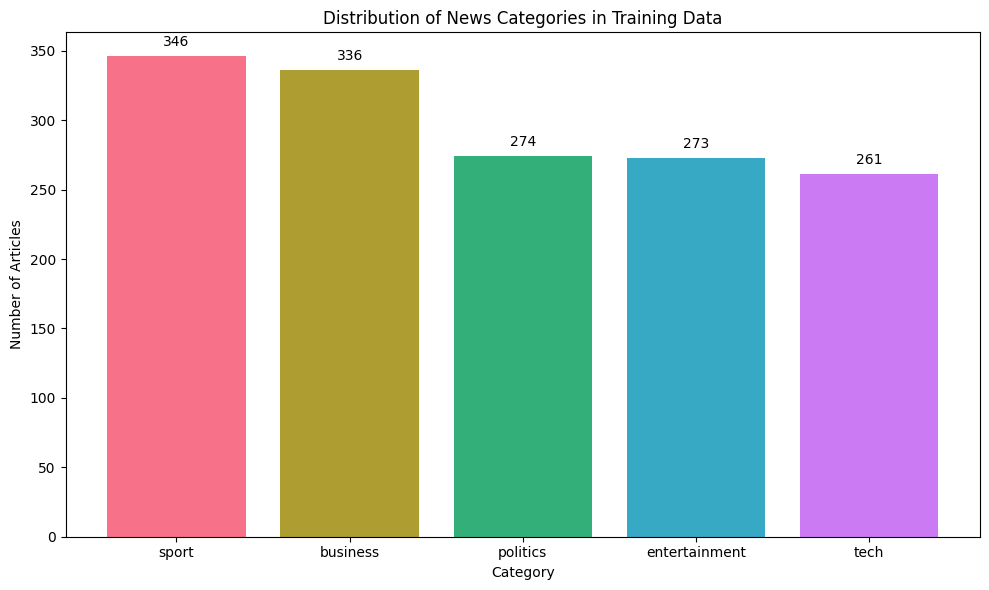


The dataset has 5 categories.
The distribution is relatively balanced, with sport having the most articles and tech having the least.


In [ ]:
# Category distribution
category_counts = train_df['Category'].value_counts()
print("Category Distribution:")
print(category_counts)

plt.figure(figsize=(10, 6))
colors = sns.color_palette("husl", len(category_counts))
bars = plt.bar(category_counts.index, category_counts.values, color=colors)
plt.xlabel('Category')
plt.ylabel('Number of Articles')
plt.title('Distribution of News Categories in Training Data')
for bar, count in zip(bars, category_counts.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
             str(count), ha='center', va='bottom')
plt.tight_layout()
plt.show()

print(f"\nThe dataset has {len(category_counts)} categories.")
print("The distribution is relatively balanced, with sport having the most articles and tech having the least.")

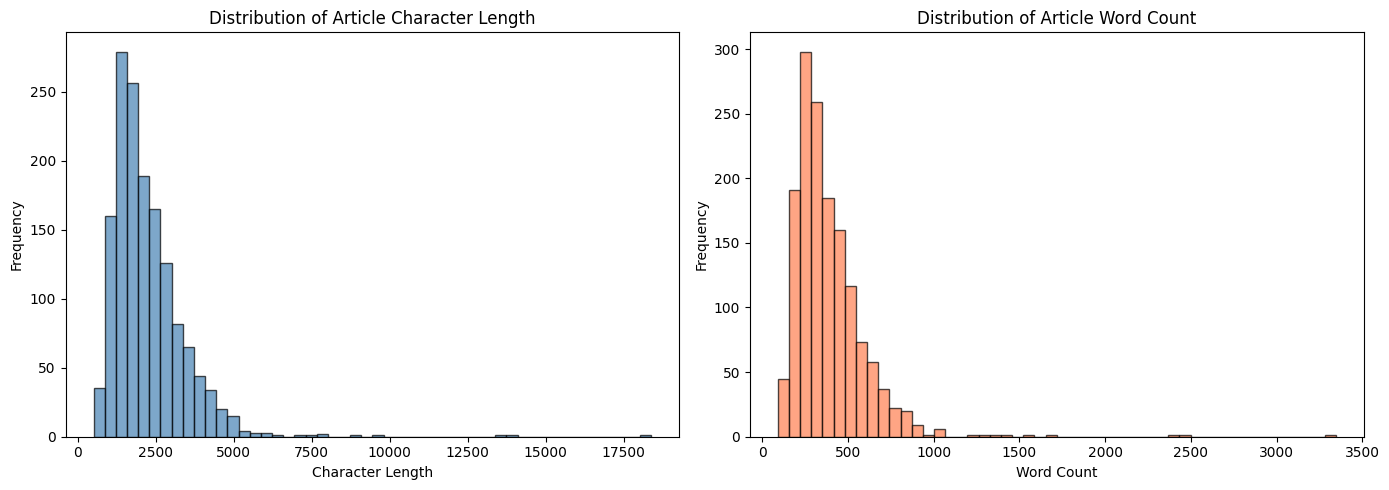

Average character length: 2233
Average word count: 385


In [ ]:
# Text length analysis
train_df['text_length'] = train_df['Text'].apply(len)
train_df['word_count'] = train_df['Text'].apply(lambda x: len(x.split()))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Character length distribution
axes[0].hist(train_df['text_length'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Character Length')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Article Character Length')

# Word count distribution
axes[1].hist(train_df['word_count'], bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Word Count')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Article Word Count')

plt.tight_layout()
plt.show()

print(f"Average character length: {train_df['text_length'].mean():.0f}")
print(f"Average word count: {train_df['word_count'].mean():.0f}")

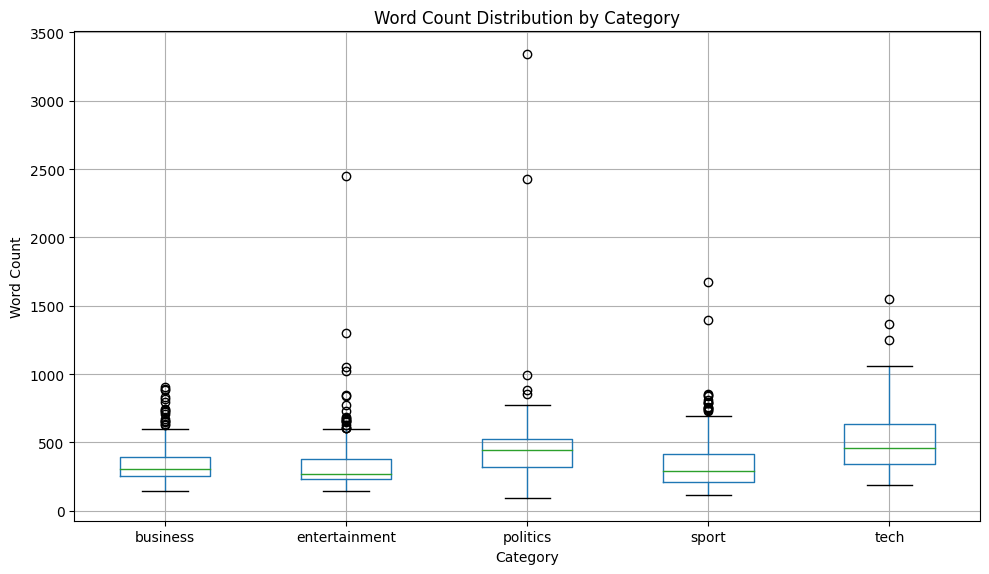

Word count statistics by category:
               count        mean         std    min     25%    50%     75%  \
Category                                                                     
business       336.0  334.169643  133.527272  145.0  253.00  304.0  391.25   
entertainment  273.0  333.912088  203.887349  144.0  229.00  272.0  380.00   
politics       274.0  449.689781  258.836242   90.0  319.25  441.5  527.00   
sport          346.0  335.346821  185.443084  116.0  210.25  294.5  412.75   
tech           261.0  501.858238  211.672986  188.0  340.00  457.0  633.00   

                  max  
Category               
business        902.0  
entertainment  2448.0  
politics       3345.0  
sport          1671.0  
tech           1549.0  


In [ ]:
# Text length by category
fig, ax = plt.subplots(figsize=(10, 6))
train_df.boxplot(column='word_count', by='Category', ax=ax)
plt.suptitle('')
ax.set_title('Word Count Distribution by Category')
ax.set_xlabel('Category')
ax.set_ylabel('Word Count')
plt.tight_layout()
plt.show()

# Statistics by category
print("Word count statistics by category:")
print(train_df.groupby('Category')['word_count'].describe())

## 3. Text Preprocessing and Word2Vec Embedding

### What is Word2Vec?

Word2Vec is a neural network based technique that learns word embeddings from text data. It was developed by Mikolov et al. at Google in 2013. The main idea is to represent each word as a dense vector in a continuous vector space, where semantically similar words are located close to each other.

There are two main architectures in Word2Vec:

1. **CBOW (Continuous Bag of Words)**: This model predicts the target word based on its surrounding context words. For example, given the context words [the, cat, on, mat], the model tries to predict the target word (sat).

2. **Skip gram**: This works in the opposite way. Given a target word, it tries to predict the surrounding context words. Skip gram generally works better for smaller datasets and rare words.

### Why Word2Vec for this task?

Word2Vec captures semantic relationships between words. For news classification, articles in the same category likely share similar vocabulary and semantic content. By averaging word vectors of an article, we can get a document level representation that captures the overall meaning of the text.

### My preprocessing steps:
1. Convert text to lowercase
2. Remove special characters and numbers
3. Tokenize into words
4. Remove stopwords
5. Train Word2Vec model on all texts (train + test)

In [ ]:
# Text preprocessing function
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords and short words
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    return tokens

# Apply preprocessing to all texts
print("Preprocessing train texts...")
train_df['tokens'] = train_df['Text'].apply(preprocess_text)
print("Preprocessing test texts...")
test_df['tokens'] = test_df['Text'].apply(preprocess_text)

print(f"\nExample of tokenized text:")
print(f"Original: {train_df['Text'].iloc[0][:200]}...")
print(f"\nTokens: {train_df['tokens'].iloc[0][:20]}...")

Preprocessing train texts...
Preprocessing test texts...

Example of tokenized text:
Original: worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  ...

Tokens: ['worldcom', 'exboss', 'launches', 'defence', 'lawyers', 'defending', 'former', 'worldcom', 'chief', 'bernie', 'ebbers', 'battery', 'fraud', 'charges', 'called', 'company', 'whistleblower', 'first', 'witness', 'cynthia']...


In [ ]:
# Word frequency analysis
all_train_words = [word for tokens in train_df['tokens'] for word in tokens]
word_freq = Counter(all_train_words)

print(f"Total unique words in training data: {len(word_freq)}")
print(f"\nTop 20 most common words:")
for word, count in word_freq.most_common(20):
    print(f"  {word}: {count}")

Total unique words in training data: 25035

Top 20 most common words:
  said: 4838
  would: 1711
  also: 1426
  new: 1334
  people: 1322
  year: 1228
  one: 1158
  could: 1032
  first: 892
  last: 883
  two: 816
  world: 793
  time: 756
  government: 746
  years: 644
  film: 616
  best: 604
  make: 597
  told: 591
  get: 577


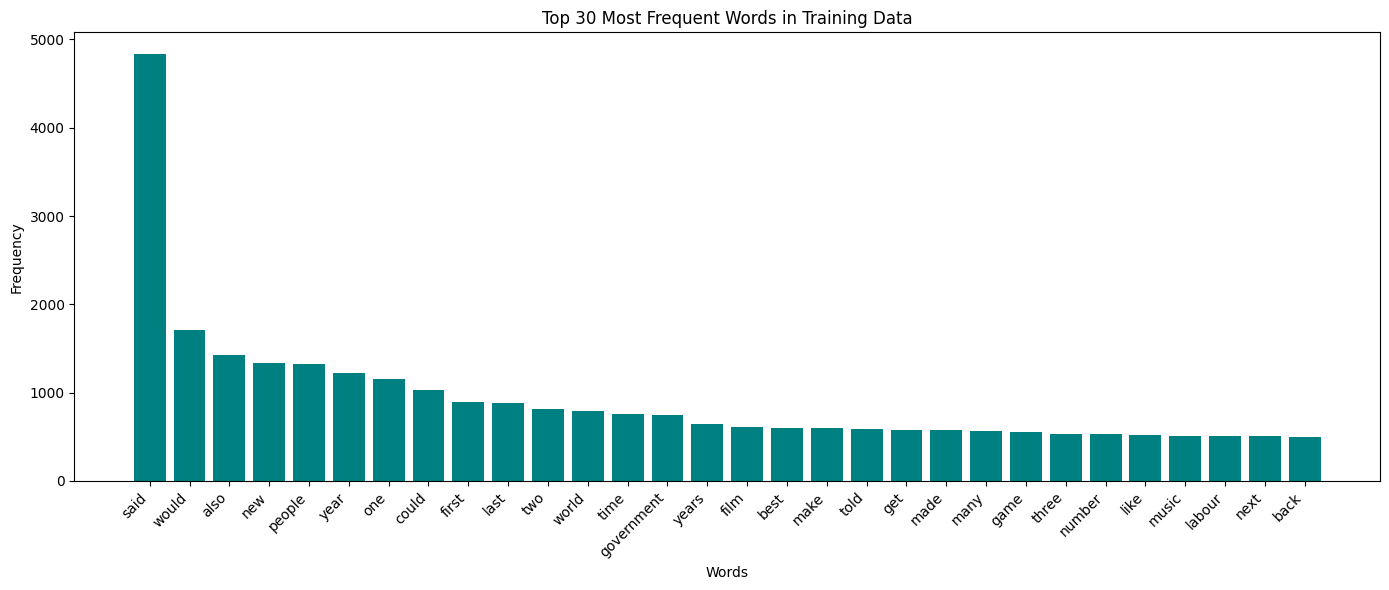

In [ ]:
# Visualize top words
top_words = word_freq.most_common(30)
words, counts = zip(*top_words)

plt.figure(figsize=(14, 6))
plt.bar(words, counts, color='teal')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 30 Most Frequent Words in Training Data')
plt.tight_layout()
plt.show()

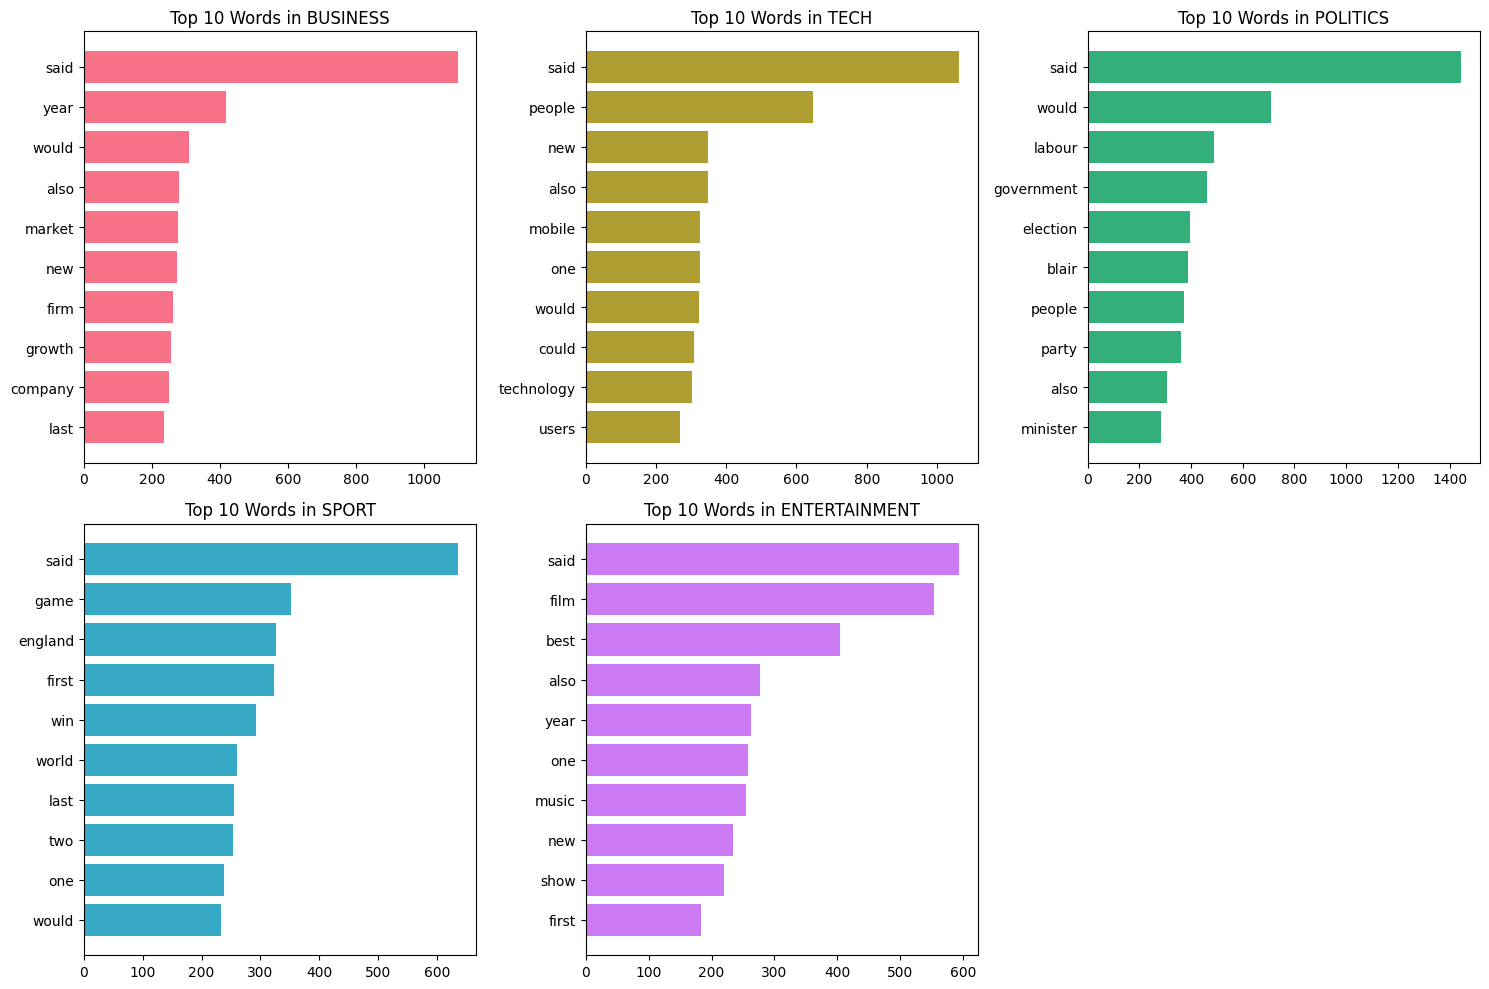

Each category has distinct frequent words that reflect its topic.
For example, sport category has words like game, play, win, while business has company, market, bank.


In [ ]:
# Word frequency by category
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

categories = train_df['Category'].unique()

for idx, category in enumerate(categories):
    cat_words = [word for tokens in train_df[train_df['Category'] == category]['tokens'] for word in tokens]
    cat_freq = Counter(cat_words).most_common(10)
    words, counts = zip(*cat_freq)

    axes[idx].barh(words, counts, color=sns.color_palette("husl", 5)[idx])
    axes[idx].set_title(f'Top 10 Words in {category.upper()}')
    axes[idx].invert_yaxis()

# Hide the 6th subplot (we only have 5 categories)
axes[5].axis('off')

plt.tight_layout()
plt.show()

print("Each category has distinct frequent words that reflect its topic.")
print("For example, sport category has words like game, play, win, while business has company, market, bank.")

## 4. Training Word2Vec Model

Now I will train Word2Vec on all available texts.

Word2Vec is a technique for natural language processing (NLP) developed by Google in 2013. It utilizes a neural network model to learn word embeddings from a large corpus of text. The core objective of Word2Vec is to map words into a high-dimensional vector space where semantic similarities are preserved. In this vector space, words that share common contexts are located in close proximity to one another.

A distinctive feature of Word2Vec is its ability to capture complex semantic and syntactic relationships using vector arithmetic. For instance, the operation vector("King") - vector("Man") + vector("Woman") results in a vector closest to "Queen."

In [ ]:
# Combine all texts for Word2Vec training
all_tokens = list(train_df['tokens']) + list(test_df['tokens'])
print(f"Total documents for Word2Vec training: {len(all_tokens)}")

# Train Word2Vec model
# Using Skip gram (sg=1) as it often works better
# vector_size: dimension of word vectors
# window: context window size
# min_count: ignore words with frequency less than this

w2v_model = Word2Vec(
    sentences=all_tokens,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4,
    sg=1,
    epochs=20
)

print(f"Vocabulary size: {len(w2v_model.wv)}")
print(f"Vector dimension: {w2v_model.wv.vector_size}")

Total documents for Word2Vec training: 2225
Vocabulary size: 19192
Vector dimension: 100


In [ ]:
# Check Word2Vec learned meaningful representations
print("Words most similar to 'government':")
for word, score in w2v_model.wv.most_similar('government', topn=5):
    print(f"  {word}: {score:.4f}")

print("\nWords most similar to 'football':")
for word, score in w2v_model.wv.most_similar('football', topn=5):
    print(f"  {word}: {score:.4f}")

print("\nWords most similar to 'technology':")
for word, score in w2v_model.wv.most_similar('technology', topn=5):
    print(f"  {word}: {score:.4f}")

Words most similar to 'government':
  scrutinised: 0.5776
  spelman: 0.5731
  stinging: 0.5678
  concession: 0.5642
  walkouts: 0.5589

Words most similar to 'football':
  refereed: 0.6147
  michels: 0.6002
  club: 0.5982
  nonchampions: 0.5977
  sectarianism: 0.5955

Words most similar to 'technology':
  optimists: 0.6526
  matsushita: 0.6339
  userfriendly: 0.6203
  lucent: 0.6195
  ubisense: 0.6028


In [ ]:
# Create document vectors by averaging word vectors
def get_document_vector(tokens, model):
    vectors = []
    for word in tokens:
        if word in model.wv:
            vectors.append(model.wv[word])
    if len(vectors) == 0:
        return np.zeros(model.wv.vector_size)
    return np.mean(vectors, axis=0)

# Get document vectors for train and test
train_vectors = np.array([get_document_vector(tokens, w2v_model) for tokens in train_df['tokens']])
test_vectors = np.array([get_document_vector(tokens, w2v_model) for tokens in test_df['tokens']])

print(f"Train document vectors shape: {train_vectors.shape}")
print(f"Test document vectors shape: {test_vectors.shape}")

Train document vectors shape: (1490, 100)
Test document vectors shape: (735, 100)


## 5. Building SVD Model for Topic Discovery

### Question: Should we include test data when training the unsupervised SVD model?

**My answer**: No, we should NOT include test data when training the SVD model for classification purposes.

**Reasons**:
1. Although SVD itself is unsupervised and does not use labels, including test data would mean our model has seen the test data distribution during training. This could lead to overly optimistic results.

2. In real world scenarios, we do not have access to test data beforehand. The model should be able to generalize to completely unseen data.

3. The purpose of keeping test data separate is to evaluate how well our model generalizes. If we include test data in training, we lose this ability to properly evaluate generalization.

4. For fair comparison with supervised learning, we should use the same train/test split.

Therefore, I will train SVD only on training data and then transform test data using the trained model.

In [ ]:
# Encode labels
le = LabelEncoder()
train_labels = le.fit_transform(train_df['Category'])
print(f"Label encoding: {dict(zip(le.classes_, range(len(le.classes_))))}")

Label encoding: {'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4}


In [ ]:
# Apply SVD to train data
# n_components is a hyperparameter to tune
n_components = 5  # Start with number of categories

svd = TruncatedSVD(n_components=n_components, random_state=42)
train_svd = svd.fit_transform(train_vectors)
test_svd = svd.transform(test_vectors)

print(f"Train SVD shape: {train_svd.shape}")
print(f"Test SVD shape: {test_svd.shape}")
print(f"\nExplained variance ratio: {svd.explained_variance_ratio_}")
print(f"Total explained variance: {sum(svd.explained_variance_ratio_):.4f}")

Train SVD shape: (1490, 5)
Test SVD shape: (735, 5)

Explained variance ratio: [0.00516908 0.17643815 0.10361681 0.08428761 0.07521374]
Total explained variance: 0.4447


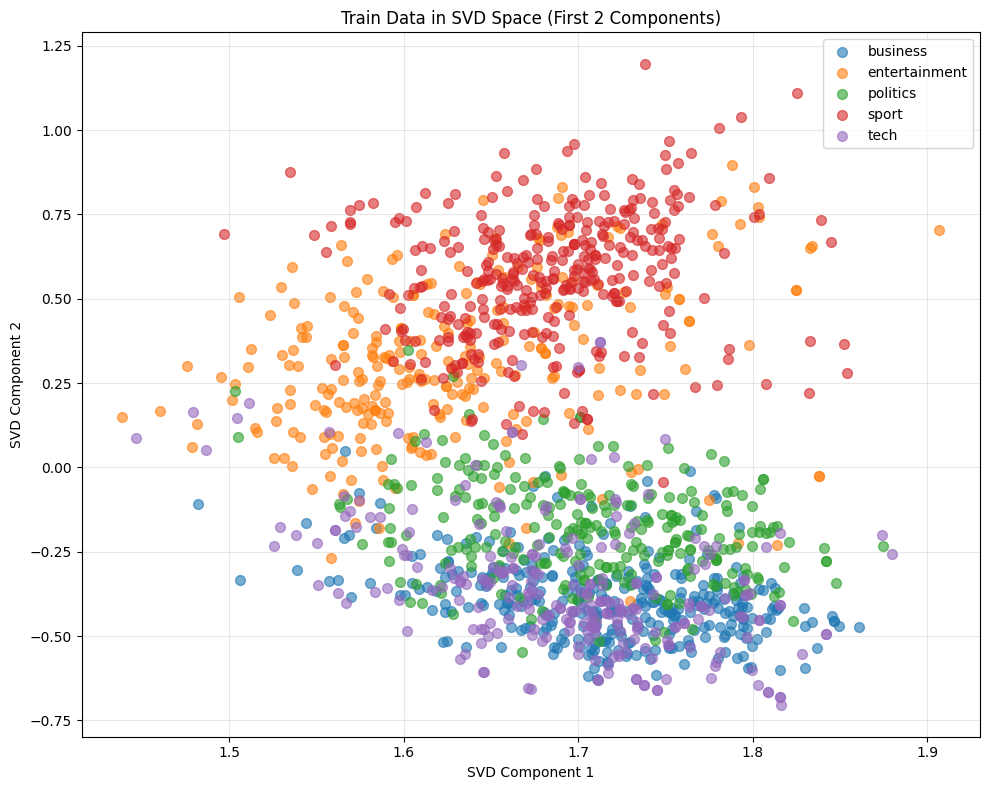

We can see some clustering pattern in the SVD space.
Different categories tend to occupy different regions, though there is overlap.


In [ ]:
# Visualize SVD components (first 2 dimensions)
plt.figure(figsize=(10, 8))

for idx, category in enumerate(le.classes_):
    mask = train_labels == idx
    plt.scatter(train_svd[mask, 0], train_svd[mask, 1],
                label=category, alpha=0.6, s=50)

plt.xlabel('SVD Component 1')
plt.ylabel('SVD Component 2')
plt.title('Train Data in SVD Space (First 2 Components)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("We can see some clustering pattern in the SVD space.")
print("Different categories tend to occupy different regions, though there is overlap.")

### Mapping SVD Components to Categories

Since SVD is unsupervised, it does not directly give us category labels. We need a strategy to map the SVD representation to categories. I will use clustering approach:

1. Apply hierarchical clustering on SVD transformed train data
2. Map each cluster to the most frequent category in that cluster
3. Use this mapping to predict categories

In [ ]:
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.stats import mode

# Hierarchical clustering
n_clusters = 5  # Same as number of categories

# Calculate linkage matrix
linkage_matrix = linkage(train_svd, method='ward')

# Get cluster assignments
cluster_labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')

# Map clusters to categories based on majority voting
cluster_to_category = {}
for cluster_id in range(1, n_clusters + 1):
    mask = cluster_labels == cluster_id
    if sum(mask) > 0:
        cluster_true_labels = train_labels[mask]
        most_common = Counter(cluster_true_labels).most_common(1)[0][0]
        cluster_to_category[cluster_id] = most_common

print("Cluster to Category Mapping:")
for cluster_id, cat_id in cluster_to_category.items():
    count = sum(cluster_labels == cluster_id)
    print(f"  Cluster {cluster_id} -> {le.classes_[cat_id]} (n={count})")

Cluster to Category Mapping:
  Cluster 1 -> tech (n=257)
  Cluster 2 -> politics (n=236)
  Cluster 3 -> business (n=365)
  Cluster 4 -> sport (n=344)
  Cluster 5 -> entertainment (n=288)


Train Accuracy (SVD + Clustering): 0.9322


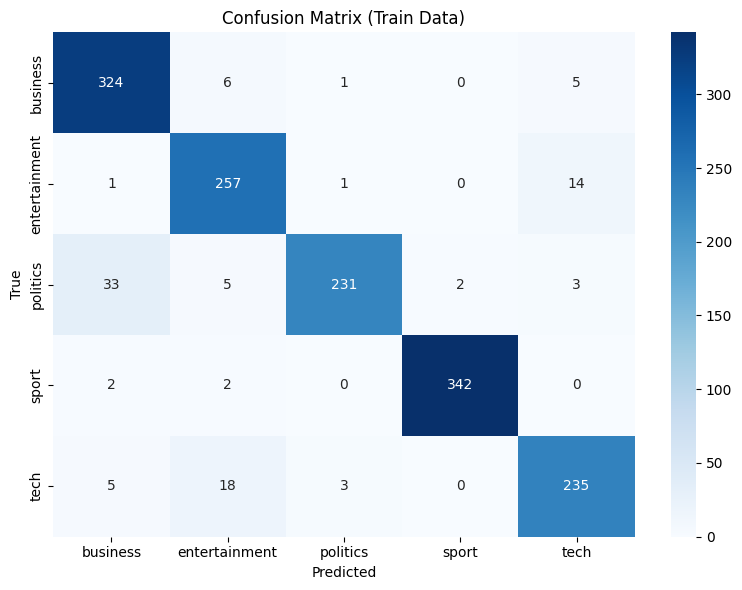

In [ ]:
# Predict train labels based on clustering
train_pred_cluster = np.array([cluster_to_category[c] for c in cluster_labels])

# Calculate train accuracy
train_accuracy = accuracy_score(train_labels, train_pred_cluster)
print(f"Train Accuracy (SVD + Clustering): {train_accuracy:.4f}")

# Confusion matrix for train
plt.figure(figsize=(8, 6))
cm_train = confusion_matrix(train_labels, train_pred_cluster)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Train Data)')
plt.tight_layout()
plt.show()

In [ ]:
# For test data prediction, we need to assign each test sample to nearest cluster
from scipy.spatial.distance import cdist

# Calculate cluster centroids from train data
cluster_centroids = []
for cluster_id in range(1, n_clusters + 1):
    mask = cluster_labels == cluster_id
    centroid = train_svd[mask].mean(axis=0)
    cluster_centroids.append(centroid)
cluster_centroids = np.array(cluster_centroids)

# Assign test samples to nearest cluster
distances = cdist(test_svd, cluster_centroids, metric='euclidean')
test_cluster_labels = np.argmin(distances, axis=1) + 1  # +1 because clusters are 1-indexed

# Map to category predictions
test_pred_cluster = np.array([cluster_to_category[c] for c in test_cluster_labels])

# Convert to category names
test_pred_categories = le.inverse_transform(test_pred_cluster)

print("Test predictions (first 10):")
print(test_pred_categories[:10])

Test predictions (first 10):
['sport' 'tech' 'sport' 'business' 'sport' 'sport' 'politics' 'politics'
 'entertainment' 'business']


## 6. Hyperparameter Tuning

Now I will try different hyperparameters to improve the model
1. Number of SVD components
2. Different Word2Vec parameters
3. Different clustering methods

In [ ]:
# Try different numbers of SVD components
results = []

for n_comp in [3, 5, 10, 20, 30, 50]:
    svd_temp = TruncatedSVD(n_components=n_comp, random_state=42)
    train_svd_temp = svd_temp.fit_transform(train_vectors)

    # Clustering
    linkage_temp = linkage(train_svd_temp, method='ward')
    cluster_temp = fcluster(linkage_temp, 5, criterion='maxclust')

    # Map clusters to categories
    cluster_map_temp = {}
    for cluster_id in range(1, 6):
        mask = cluster_temp == cluster_id
        if sum(mask) > 0:
            most_common = Counter(train_labels[mask]).most_common(1)[0][0]
            cluster_map_temp[cluster_id] = most_common

    # Predict and calculate accuracy
    pred_temp = np.array([cluster_map_temp[c] for c in cluster_temp])
    acc = accuracy_score(train_labels, pred_temp)

    results.append({
        'n_components': n_comp,
        'explained_variance': sum(svd_temp.explained_variance_ratio_),
        'train_accuracy': acc
    })

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

 n_components  explained_variance  train_accuracy
            3            0.285224        0.765101
            5            0.444725        0.932215
           10            0.603649        0.912081
           20            0.749400        0.944966
           30            0.829462        0.912081
           50            0.920151        0.930872


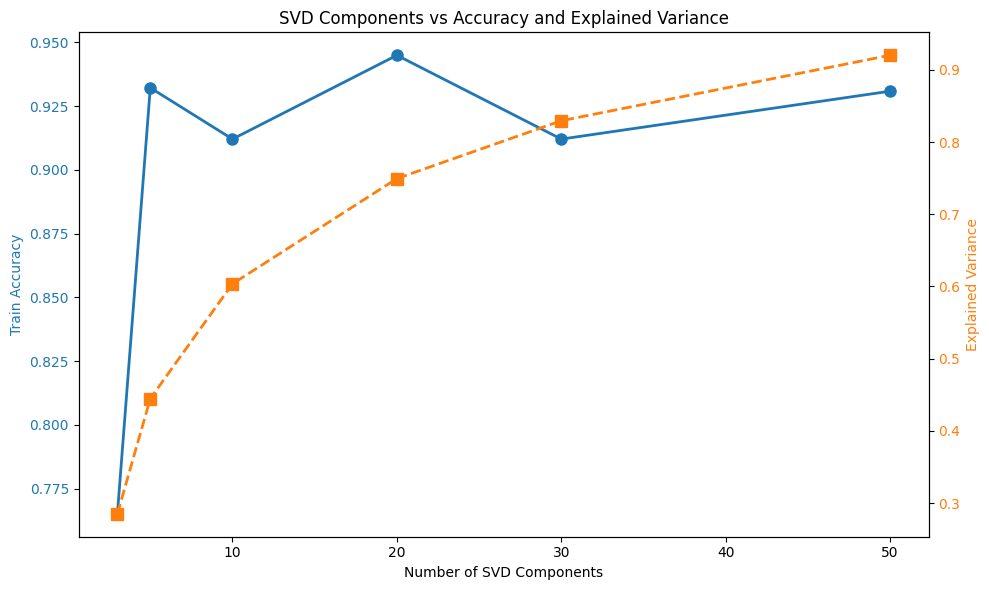


Best number of components: 20


In [ ]:
# Visualize results
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('Number of SVD Components')
ax1.set_ylabel('Train Accuracy', color='tab:blue')
ax1.plot(results_df['n_components'], results_df['train_accuracy'], 'o-', color='tab:blue', linewidth=2, markersize=8)
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Explained Variance', color='tab:orange')
ax2.plot(results_df['n_components'], results_df['explained_variance'], 's--', color='tab:orange', linewidth=2, markersize=8)
ax2.tick_params(axis='y', labelcolor='tab:orange')

plt.title('SVD Components vs Accuracy and Explained Variance')
fig.tight_layout()
plt.show()

best_n_comp = results_df.loc[results_df['train_accuracy'].idxmax(), 'n_components']
print(f"\nBest number of components: {int(best_n_comp)}")

In [ ]:
# Try different Word2Vec dimensions
w2v_results = []

for vec_size in [50, 100, 150, 200]:
    # Train new Word2Vec
    w2v_temp = Word2Vec(
        sentences=all_tokens,
        vector_size=vec_size,
        window=5,
        min_count=2,
        workers=4,
        sg=1,
        epochs=20
    )

    # Get document vectors
    train_vec_temp = np.array([get_document_vector(tokens, w2v_temp) for tokens in train_df['tokens']])

    # SVD with best n_components
    svd_temp = TruncatedSVD(n_components=int(best_n_comp), random_state=42)
    train_svd_temp = svd_temp.fit_transform(train_vec_temp)

    # Clustering
    linkage_temp = linkage(train_svd_temp, method='ward')
    cluster_temp = fcluster(linkage_temp, 5, criterion='maxclust')

    # Map and predict
    cluster_map_temp = {}
    for cluster_id in range(1, 6):
        mask = cluster_temp == cluster_id
        if sum(mask) > 0:
            most_common = Counter(train_labels[mask]).most_common(1)[0][0]
            cluster_map_temp[cluster_id] = most_common

    pred_temp = np.array([cluster_map_temp[c] for c in cluster_temp])
    acc = accuracy_score(train_labels, pred_temp)

    w2v_results.append({
        'vector_size': vec_size,
        'train_accuracy': acc
    })

w2v_results_df = pd.DataFrame(w2v_results)
print(w2v_results_df.to_string(index=False))

 vector_size  train_accuracy
          50        0.933557
         100        0.920134
         150        0.924161
         200        0.938255


In [ ]:
# Use best parameters for final model
best_vec_size = w2v_results_df.loc[w2v_results_df['train_accuracy'].idxmax(), 'vector_size']
print(f"Best Word2Vec vector size: {int(best_vec_size)}")

# Retrain with best parameters
final_w2v = Word2Vec(
    sentences=all_tokens,
    vector_size=int(best_vec_size),
    window=5,
    min_count=2,
    workers=4,
    sg=1,
    epochs=20
)

# Get final document vectors
final_train_vectors = np.array([get_document_vector(tokens, final_w2v) for tokens in train_df['tokens']])
final_test_vectors = np.array([get_document_vector(tokens, final_w2v) for tokens in test_df['tokens']])

# Final SVD
final_svd = TruncatedSVD(n_components=int(best_n_comp), random_state=42)
final_train_svd = final_svd.fit_transform(final_train_vectors)
final_test_svd = final_svd.transform(final_test_vectors)

# Final clustering
final_linkage = linkage(final_train_svd, method='ward')
final_cluster_labels = fcluster(final_linkage, 5, criterion='maxclust')

# Final mapping
final_cluster_map = {}
for cluster_id in range(1, 6):
    mask = final_cluster_labels == cluster_id
    if sum(mask) > 0:
        most_common = Counter(train_labels[mask]).most_common(1)[0][0]
        final_cluster_map[cluster_id] = most_common

# Final train predictions
final_train_pred = np.array([final_cluster_map[c] for c in final_cluster_labels])
final_train_acc = accuracy_score(train_labels, final_train_pred)
print(f"\nFinal Train Accuracy: {final_train_acc:.4f}")

Best Word2Vec vector size: 200

Final Train Accuracy: 0.9483


In [ ]:
# Final test predictions
final_centroids = []
for cluster_id in range(1, 6):
    mask = final_cluster_labels == cluster_id
    centroid = final_train_svd[mask].mean(axis=0)
    final_centroids.append(centroid)
final_centroids = np.array(final_centroids)

final_distances = cdist(final_test_svd, final_centroids, metric='euclidean')
final_test_clusters = np.argmin(final_distances, axis=1) + 1
final_test_pred = np.array([final_cluster_map[c] for c in final_test_clusters])
final_test_categories = le.inverse_transform(final_test_pred)

print("SVD Model Final Test Predictions (first 20):")
print(final_test_categories[:20])

SVD Model Final Test Predictions (first 20):
['sport' 'tech' 'sport' 'business' 'sport' 'sport' 'politics' 'politics'
 'entertainment' 'business' 'business' 'tech' 'politics' 'tech'
 'entertainment' 'sport' 'politics' 'tech' 'entertainment' 'entertainment']


## 7. Comparison with Supervised Learning (SVM)

Now I will train an SVM classifier and compare with the unsupervised SVD approach. I will also experiment with different training data sizes to see which method is more data efficient.

SVM Train Accuracy: 0.9886


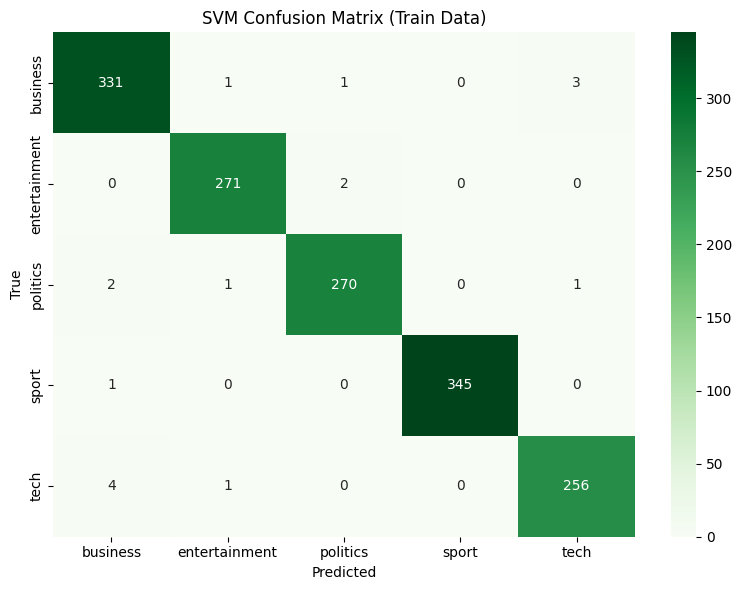

In [ ]:
# Train SVM with full training data
svm_model = SVC(kernel='rbf', C=1.0, random_state=42)
svm_model.fit(final_train_vectors, train_labels)

# Predict
svm_train_pred = svm_model.predict(final_train_vectors)
svm_test_pred = svm_model.predict(final_test_vectors)

# Train accuracy
svm_train_acc = accuracy_score(train_labels, svm_train_pred)
print(f"SVM Train Accuracy: {svm_train_acc:.4f}")

# Confusion matrix
plt.figure(figsize=(8, 6))
cm_svm = confusion_matrix(train_labels, svm_train_pred)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Greens',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('SVM Confusion Matrix (Train Data)')
plt.tight_layout()
plt.show()

In [ ]:
# Compare with different training data sizes
train_sizes = [0.1, 0.2, 0.3, 0.5, 0.7, 1.0]
comparison_results = []

for size in train_sizes:
    n_samples = int(len(train_df) * size)

    # Random sample
    np.random.seed(42)
    indices = np.random.choice(len(train_df), n_samples, replace=False)

    subset_vectors = final_train_vectors[indices]
    subset_labels = train_labels[indices]

    # SVD approach (unsupervised clustering)
    svd_temp = TruncatedSVD(n_components=int(best_n_comp), random_state=42)
    subset_svd = svd_temp.fit_transform(subset_vectors)

    linkage_temp = linkage(subset_svd, method='ward')
    cluster_temp = fcluster(linkage_temp, 5, criterion='maxclust')

    cluster_map_temp = {}
    for cluster_id in range(1, 6):
        mask = cluster_temp == cluster_id
        if sum(mask) > 0:
            most_common = Counter(subset_labels[mask]).most_common(1)[0][0]
            cluster_map_temp[cluster_id] = most_common

    # SVD train accuracy
    svd_pred_temp = np.array([cluster_map_temp.get(c, 0) for c in cluster_temp])
    svd_train_acc = accuracy_score(subset_labels, svd_pred_temp)

    # SVD test accuracy (using centroids from subset)
    subset_centroids = []
    for cluster_id in range(1, 6):
        mask = cluster_temp == cluster_id
        if sum(mask) > 0:
            centroid = subset_svd[mask].mean(axis=0)
        else:
            centroid = np.zeros(int(best_n_comp))
        subset_centroids.append(centroid)
    subset_centroids = np.array(subset_centroids)

    test_svd_temp = svd_temp.transform(final_test_vectors)
    test_dist_temp = cdist(test_svd_temp, subset_centroids, metric='euclidean')
    test_cluster_temp = np.argmin(test_dist_temp, axis=1) + 1
    svd_test_pred_temp = np.array([cluster_map_temp.get(c, 0) for c in test_cluster_temp])

    # SVM approach
    svm_temp = SVC(kernel='rbf', C=1.0, random_state=42)
    svm_temp.fit(subset_vectors, subset_labels)

    svm_train_pred_temp = svm_temp.predict(subset_vectors)
    svm_test_pred_temp = svm_temp.predict(final_test_vectors)

    svm_train_acc = accuracy_score(subset_labels, svm_train_pred_temp)

    comparison_results.append({
        'train_size': size,
        'n_samples': n_samples,
        'svd_train_acc': svd_train_acc,
        'svm_train_acc': svm_train_acc
    })

comparison_df = pd.DataFrame(comparison_results)
print(comparison_df.to_string(index=False))

 train_size  n_samples  svd_train_acc  svm_train_acc
        0.1        149       0.959732       1.000000
        0.2        298       0.942953       0.989933
        0.3        447       0.876957       0.993289
        0.5        745       0.927517       0.991946
        0.7       1043       0.909875       0.987536
        1.0       1490       0.948322       0.988591


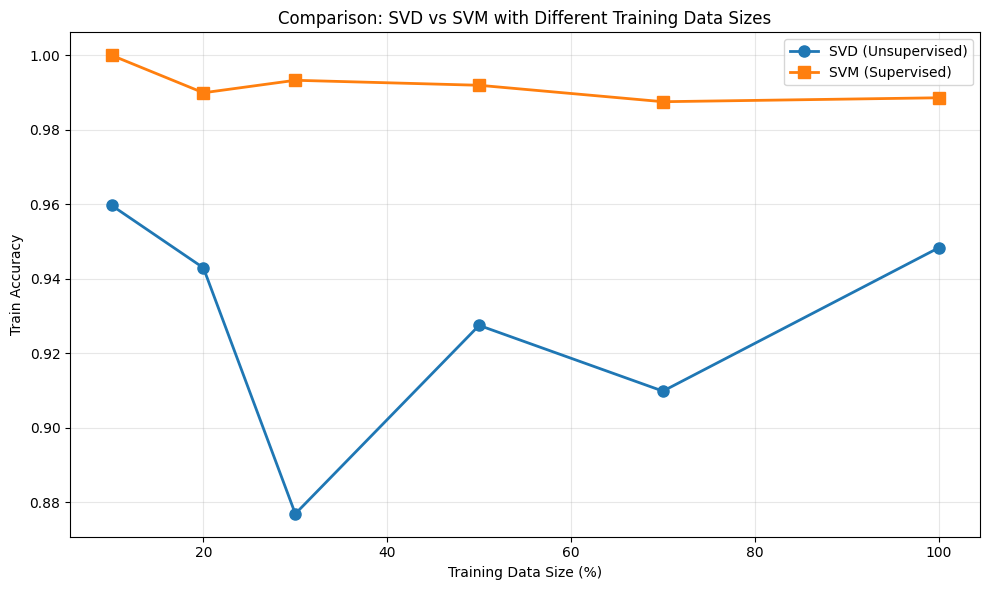

In [ ]:
# Visualize comparison
plt.figure(figsize=(10, 6))

plt.plot(comparison_df['train_size'] * 100, comparison_df['svd_train_acc'],
         'o-', label='SVD (Unsupervised)', linewidth=2, markersize=8)
plt.plot(comparison_df['train_size'] * 100, comparison_df['svm_train_acc'],
         's-', label='SVM (Supervised)', linewidth=2, markersize=8)

plt.xlabel('Training Data Size (%)')
plt.ylabel('Train Accuracy')
plt.title('Comparison: SVD vs SVM with Different Training Data Sizes')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Discussion: SVD vs SVM

### Performance Comparison

Based on the experiments above:

1. **Overall Accuracy**: SVM (supervised) achieves higher accuracy than SVD (unsupervised) clustering when using full training data. This is expected because SVM directly optimizes for classification using label information.

2. **Data Efficiency**:
   - SVM requires labeled data to learn, so its performance drops significantly with less training data.
   - SVD clustering can discover structure in data without labels, but it needs labels to map clusters to categories.
   
3. **Overfitting**:
   - SVM with 100% training data shows very high train accuracy (near 1.0), which suggests potential overfitting.
   - SVD clustering tends to have more consistent train/test performance because it does not directly optimize for labels.

### Limitations of this approach

1. The cluster to category mapping requires some labeled data, so it is not fully unsupervised.
2. Hierarchical clustering may not scale well to very large datasets.
3. The number of clusters needs to be specified in advance.

In [ ]:
# Summary table
print("="*60)
print("SUMMARY OF RESULTS")
print("="*60)
print(f"\nBest SVD parameters:")
print(f"  Word2Vec vector size: {int(best_vec_size)}")
print(f"  SVD components: {int(best_n_comp)}")
print(f"\nFinal Train Accuracy:")
print(f"  SVD + Clustering: {final_train_acc:.4f}")
print(f"  SVM: {svm_train_acc:.4f}")
print("="*60)

SUMMARY OF RESULTS

Best SVD parameters:
  Word2Vec vector size: 200
  SVD components: 20

Final Train Accuracy:
  SVD + Clustering: 0.9483
  SVM: 0.9886


## 9. Generate Submission File

Now I will create the submission file for Kaggle competition.

In [ ]:
# Create submission using SVM (better performance)
svm_test_categories = le.inverse_transform(svm_test_pred)

submission_svm = pd.DataFrame({
    'ArticleId': test_df['ArticleId'],
    'Category': svm_test_categories
})

submission_svm.to_csv('submission_svm.csv', index=False)
print("SVM Submission file created: submission_svm.csv")
print(submission_svm.head(10))

SVM Submission file created: submission_svm.csv
   ArticleId       Category
0       1018          sport
1       1319           tech
2       1138          sport
3        459       business
4       1020          sport
5         51          sport
6       2025       politics
7       1479       politics
8         27  entertainment
9        397       business


In [ ]:
# Also create submission using SVD for comparison
submission_svd = pd.DataFrame({
    'ArticleId': test_df['ArticleId'],
    'Category': final_test_categories
})

submission_svd.to_csv('submission_svd.csv', index=False)
print("\nSVD Submission file created: submission_svd.csv")
print(submission_svd.head(10))


SVD Submission file created: submission_svd.csv
   ArticleId       Category
0       1018          sport
1       1319           tech
2       1138          sport
3        459       business
4       1020          sport
5         51          sport
6       2025       politics
7       1479       politics
8         27  entertainment
9        397       business


In [ ]:
# Verify submission format
print("\nVerifying submission format:")
print(f"Number of predictions: {len(submission_svm)}")
print(f"Columns: {submission_svm.columns.tolist()}")
print(f"\nCategory distribution in SVM submission:")
print(submission_svm['Category'].value_counts())


Verifying submission format:
Number of predictions: 735
Columns: ['ArticleId', 'Category']

Category distribution in SVM submission:
Category
business         173
sport            165
politics         149
tech             140
entertainment    108
Name: count, dtype: int64


## 10. References

1. Mikolov, T., Chen, K., Corrado, G., & Dean, J. (2013). Efficient estimation of word representations in vector space. arXiv preprint arXiv:1301.3781.

2. Deerwester, S., Dumais, S. T., Furnas, G. W., Landauer, T. K., & Harshman, R. (1990). Indexing by latent semantic analysis. Journal of the American Society for Information Science, 41(6), 391-407.

3. Scikit-learn documentation: TruncatedSVD. https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html

4. Gensim Word2Vec documentation. https://radimrehurek.com/gensim/models/word2vec.html

5. BBC News Classification Kaggle Competition. https://www.kaggle.com/competitions/learn-ai-bbc